In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torch.optim as optim


import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score


import json, os

In [3]:
# HYPERPARAMETERS

train_size = 0.8
test_size=0.2
device = 'cuda'
cpu = 'cpu'

In [4]:
with open("mapping.json", 'r') as f:
    mapping = json.load(f)
    

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate= (.15, .15), scale = (0.85, 1.15)),

    transforms.Resize((224,224)), #Resize data to be 224x224.
    transforms.ToTensor(),
    # transforms.Lambda(CopySingleChannels()) #transforms both RGB and grayscale to same tensor size by stacking copies of grayscales along first axis.    
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()    
])

In [5]:

full_dataset = torchvision.datasets.ImageFolder(
    root='./dataset',
    transform=None
)


class myDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y
   



In [6]:
train, test = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

In [7]:
train_dataset = myDataset(train, transform=train_transform)
test_dataset = myDataset(test, transform=test_transform)

In [17]:
batch_size=64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True, 
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False   
)

label: airplanes-101 (index - 251)


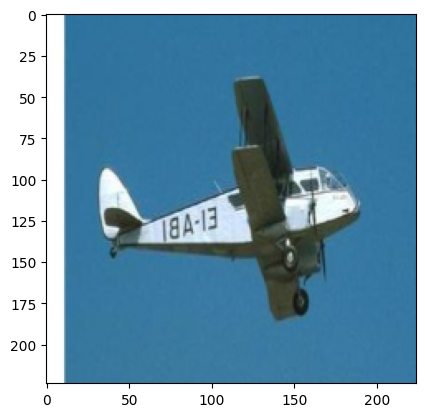

In [9]:
#visualize an image from test_dataset

i = 1135

image = test_dataset[i][0].permute(1, 2, 0).numpy()
label = mapping[str(test_dataset[i][1]+1)] #+1 is required, because the "class 1" in folders, is class 0 when torch loads it

print(f"label: {label} (index - {test_dataset[i][1]+1})")
plt.imshow(image)

In [20]:
@torch.no_grad()
def print_test_details(model:nn.Module, loss, test_loader:torch.utils.data.DataLoader=test_loader):

    model.eval()

    top_1_correct = 0
    top_5_correct = 0
    total_loss = 0
    
    for test_features, test_labels in iter(test_loader):

        test_features = test_features.to(device)
        test_labels = test_labels.to(device)
        size = len(test_features)

        model_output:torch.Tensor = model(test_features)
        total_loss += loss(model_output, test_labels).item()*size


        all_labels = np.array(range(model_output.shape[1]))
    
        top_1_correct += top_k_accuracy_score(test_labels.to('cpu'), model_output.to('cpu'), k=1, labels=all_labels)*size
        top_5_correct += top_k_accuracy_score(test_labels.to('cpu'), model_output.to('cpu'), k=5, labels=all_labels)*size

    top_1_accuracy = top_1_correct/len(test_loader.dataset)
    top_5_accuracy = top_5_correct/len(test_loader.dataset)
    loss_value = total_loss/len(test_loader.dataset)

    print(f"Test Score - Loss: {loss_value}, top-1 accuracy: {top_1_accuracy}, top-5 accuracy: {top_5_accuracy}")

    return (loss_value, top_1_accuracy, top_5_accuracy)


In [ ]:
def conv3x3(in_channels:int, out_channels:int, stride:int=1, padding='valid'):
    return nn.Conv2d(
        in_channels=in_channels, 
        out_channels=out_channels, 
        kernel_size=3,
        padding=padding,
        stride=stride,
        bias=False
    )

def conv1x1(in_channels:int, out_channels:int, stride:int=1):
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        bias=False
    )


class IdentityBlock_2(nn.Module):

    def __init__(self):
        pass

    def forard(self, X):
        pass




class Resnet(nn.Module):

    def __init__(self):
        super().__init__()

    

    def forward(self, input):
        pass


In [ ]:

model = torchvision.models.resnet18(num_classes=256)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

In [14]:
# total_params = sum(p.numel() for p in model.parameters())
# total_params


In [ ]:
for epoch in range(4):

    start = time.time()
    total_training_loss = 0
    total_training_samples = 0
    total_training_correct_classfied = 0

    model.train()

    for iteration, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        output_predictions = model(images)

        loss_value = criterion(output_predictions, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        

        
        total_training_loss += loss_value.item()*labels.shape[0]
        total_training_samples += labels.shape[0]
        _, predicted = torch.max(output_predictions, dim=1)
        total_training_correct_classfied += (labels == predicted).sum().item()

        if iteration%10==0:
            print(f"iteration {iteration+1} done.")

    print(f"epoch: {epoch+1}, train loss: {total_training_loss/total_training_samples}, train accuracy: {total_training_correct_classfied/total_training_samples}, time taken: {time.time()-start}")
    print_test_details(model, criterion)
    print()





In [28]:
torch.save(model.state_dict(), "resnet18_scratch_weights.pth")

In [27]:
print_test_details(model, criterion)


Test Score - Loss: 2.7991777161290137, top-1 accuracy: 0.4054734721289456, top-5 accuracy: 0.6371725990597716


(2.7991777161290137,
 np.float64(0.4054734721289456),
 np.float64(0.6371725990597716))